In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
# Define a custom dataset for loading the original images and using final output images as masks
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.image_dir))

    def __getitem__(self, idx):
        img_name = os.listdir(self.image_dir)[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")  # Assuming final output images are RGB
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [3]:
# U-Net implementation for semantic segmentation
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder
        self.encoder_conv1 = self.conv_block(in_channels, 64)
        self.encoder_conv2 = self.conv_block(64, 128)
        self.encoder_conv3 = self.conv_block(128, 256)
        self.encoder_conv4 = self.conv_block(256, 512)
        
        # Decoder
        self.decoder_upconv3 = self.conv_transpose(512, 256)
        self.decoder_upconv2 = self.conv_transpose(256, 128)
        self.decoder_upconv1 = self.conv_transpose(128, 64)
        
        self.decoder_conv3 = self.conv_block(512, 256)
        self.decoder_conv2 = self.conv_block(256, 128)
        self.decoder_conv1 = self.conv_block(128, out_channels)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def conv_transpose(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        # Encoder
        enc1 = self.encoder_conv1(x)
        enc2 = self.encoder_conv2(nn.MaxPool2d(2)(enc1))
        enc3 = self.encoder_conv3(nn.MaxPool2d(2)(enc2))
        enc4 = self.encoder_conv4(nn.MaxPool2d(2)(enc3))
        
        # Decoder
        dec3 = self.decoder_upconv3(enc4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder_conv3(dec3)
        
        dec2 = self.decoder_upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder_conv2(dec2)
        
        dec1 = self.decoder_upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder_conv1(dec1)
        
        return dec1

In [4]:
# Set the paths to your original images and semantic segmented images
image_dir = "/home/tamoghna/catkin_ws/src/dynamix/scripts/input/dataset/1/"
mask_dir = "/home/tamoghna/catkin_ws/src/dynamix/scripts/input/dataset/2/"


In [5]:
# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [6]:
# Create the dataset and data loader
dataset = CustomDataset(image_dir, mask_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [7]:
# Initialize the model
in_channels = 3  # Number of input channels (RGB)
out_channels = 5  # Number of output classes (based on your dataset)
model = UNet(in_channels, out_channels)

In [8]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
# Training loop
num_epochs = 10
progress_bar = tqdm(total=len(dataloader))
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        
        # Convert RGB mask images to class indices
        masks = torch.argmax(masks, dim=1).long()

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        progress_bar.set_postfix(loss=running_loss / len(dataloader))
        progress_bar.update(1)


progress_bar.close()

Epoch 10/10: : 7440it [27:46,  4.46it/s, loss=0.351]                        


In [12]:
# Save the trained model
torch.save(model.state_dict(), "seggs.pth")

In [13]:
model = UNet(in_channels, out_channels)  # Initialize the UNet model
model.load_state_dict(torch.load())  # Load the saved model weights
model.eval()  # Set the model to evaluation mode
"/home/tamoghna/catkin_ws/src/dynamix/scripts/seggs.pth"

UNet(
  (encoder_conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (encoder_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder_upconv3):

In [14]:
image = Image.open("/home/tamoghna/catkin_ws/src/dynamix/scripts/test.jpg").convert("RGB")  # Load the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
image = transform(image).unsqueeze(0)  # Apply transformations and add a batch dimension


In [15]:
with torch.no_grad():
    output = model(image.to(device))  # Pass the preprocessed image through the model


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
output = torch.argmax(output, dim=1)  # Convert the output to class indices
output_image = output.squeeze(0).cpu().numpy()  # Remove the batch dimension and move to CPU


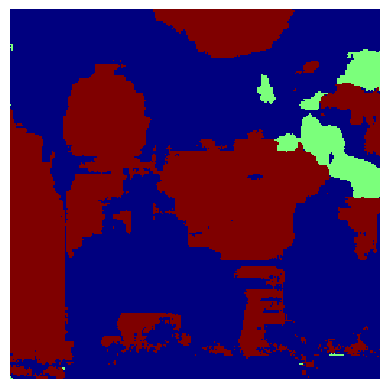

In [19]:
# Load the saved model weights
model.load_state_dict(torch.load("/home/tamoghna/catkin_ws/src/dynamix/scripts/seggs.pth"))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Preprocess the input image
input_image = Image.open("/home/tamoghna/catkin_ws/src/dynamix/scripts/test3.jpeg").convert("RGB")
input_image = transform(input_image).unsqueeze(0).to(device)

# Perform inference using the model
with torch.no_grad():
    output = model(input_image)

# Post-process the output
output = torch.argmax(output, dim=1)
output_image = output.squeeze(0).cpu().numpy()

# Visualize the segmentation result
import matplotlib.pyplot as plt

cmap = plt.get_cmap("jet", out_channels)  # Assuming out_channels is the number of classes
plt.imshow(output_image, cmap=cmap)
plt.axis("off")
plt.show()

